# Sentiment Analysis

---

## Imports

In [41]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertTokenizerFast, AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
import matplotlib.ticker as ticker

In [2]:
#path = kagglehub.model_download("omlande/bert-multiclassification-sentiment-analysis/pyTorch/default")
#print("Path to model files:", path)

## File Paths

In [4]:
# Defining file paths
config_path = "../TM2025_project/bert_emotion_classifier/config.json"
model_path = "../TM2025_project/bert_emotion_classifier/model.safetensors"
vocab_path = "../TM2025_project/bert_emotion_classifier/vocab.txt"
data_path = "../TM2025_project/data/preprocessed_letters.csv"
output_path_1 = "../TM2025_project/sentiment_predictions_1.csv"
output_path_2 = "../TM2025_project/sentiment_predictions_2.csv"
chunk_output_path = "../TM2025_project/chunk_level_predictions.csv"
output_path_3 = "../TM2025_project/sentiment_predictions_3.csv"

## Helper Functions

In [9]:
# "Chunking"
def chunking_express(text, chunk_size=130):
    words = text.strip().split()
    return [" ".join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

# Finding best chunk size
def find_best_chunk_size(min_size=50, max_size=150, step=-10):
    best_chunk_size = None
    min_neutral_count = float('inf')
    
    for chunk_size in range(max_size, min_size - 1, step):
        print(f"Evaluating chunk size: {chunk_size}")
        
        final_preds = []

        for letter in tqdm(df[text_column]):
            chunks = chunking_express(letter, chunk_size=chunk_size)
            dataset = ChunkDataset(chunks, tokenizer)
            dataloader = DataLoader(dataset, batch_size=8)

            all_logits = []
            with torch.no_grad():
                for batch in dataloader:
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask']
                    )
                    all_logits.append(outputs.logits)

            avg_logits = torch.cat(all_logits, dim=0).max(dim=0).values
            pred_idx = torch.argmax(avg_logits).item()
            final_preds.append(id2label[pred_idx])
        
        # Count neutral predictions
        neutral_count = sum(1 for pred in final_preds if pred.lower() == "neutral")
        print(f"Neutral predictions: {neutral_count}")

        # Check for best
        if neutral_count < min_neutral_count:
            min_neutral_count = neutral_count
            best_chunk_size = chunk_size
    
    print(f"\nBest chunk size: {best_chunk_size} with {min_neutral_count} neutral predictions")
    return best_chunk_size

# Plotting
def plot_emotion_distribution(title, csv_path):
    # Loading CSV
    df = pd.read_csv(csv_path)

    # Getting counts and percentages
    emotion_counts_abs = df['predicted_sentiment'].value_counts()
    emotion_counts_pct = (emotion_counts_abs / len(df)) * 100

    # Plotting the bar graph
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')  # Transparent background
    bars = ax.bar(emotion_counts_abs.index, emotion_counts_abs.values, color='orange')

    # Annotating each bar with percentage
    for bar, pct in zip(bars, emotion_counts_pct.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{pct:.1f}%', 
                ha='center', va='bottom', fontsize=10)

    # Labels and styling
    ax.set_title(title)
    ax.set_ylabel("Number of Letters")
    ax.set_xlabel("Emotion")
    ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_facecolor('none')  # Transparent axes background

    plt.tight_layout()
    plt.show()

def analyze_sentiment(text):
    tokens = tokenizer([text], return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(input_ids=tokens.input_ids, attention_mask=tokens.attention_mask)
        probabilities = softmax(outputs.logits, dim=1)
    positive_prob = probabilities[0][1].item()
    negative_prob = probabilities[0][0].item()
    #prediction = "Positive" if positive_prob >= 0.5 else "Negative"
    prediction = "Positive" if positive_prob > 0.5 else "Negative" if positive_prob < 0.5 else "Neutral"
    return positive_prob, negative_prob, prediction

def plot_emotion_distribution_2(title, csv_path):
    # Loading CSV
    df = pd.read_csv(csv_path)

    # Getting counts and percentages
    emotion_counts_abs = df['Prediction'].value_counts()
    emotion_counts_pct = (emotion_counts_abs / len(df)) * 100

    # Plotting the bar graph
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')  # Transparent background
    bars = ax.bar(emotion_counts_abs.index, emotion_counts_abs.values, color='orange')

    # Annotating each bar with percentage
    for bar, pct in zip(bars, emotion_counts_pct.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{pct:.1f}%', 
                ha='center', va='bottom', fontsize=10)

    # Labels and styling
    ax.set_title(title)
    ax.set_ylabel("Number of Letters")
    ax.set_xlabel("Sentiment")
    ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_facecolor('none')  # Transparent axes background

    plt.tight_layout()
    plt.show()

## BERT Multi-classification

### No Chunking

In [13]:
# Loading the model
state_dict = load_file(model_path)
config = BertConfig.from_json_file(config_path)
model = BertForSequenceClassification(config)
model.load_state_dict(state_dict)
model.eval()

# Load tokenizer
tokenizer = BertTokenizer(
    vocab_file=vocab_path,
    do_lower_case=True,
    unk_token="[UNK]",
    sep_token="[SEP]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    mask_token="[MASK]"
)

# Load data
df = pd.read_csv(data_path)
text_column = "letter"

In [14]:
# Define Dataset class
class LetterDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encodings.items()}

In [15]:
# Create dataset and dataloader
dataset = LetterDataset(df[text_column].tolist(), tokenizer)
dataloader = DataLoader(dataset, batch_size=8)

In [16]:
# Run predictions
all_preds = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [04:14<00:00,  4.99s/it]


In [17]:
# Map predictions to labels
id2label = {
    int(k): v for k, v in model.config.id2label.items()
}
df["predicted_sentiment"] = [id2label[p] for p in all_preds]

In [18]:
# Save results
df.to_csv(output_path_1, index=False)
print("Sentiment analysis completed. Results saved to 'sentiment_predictions_1.csv'.")

Sentiment analysis completed. Results saved to 'sentiment_predictions.csv'.


#### Plots

### Chunking

In [21]:
# Loading model
config = BertConfig.from_json_file(config_path)
state_dict = load_file(model_path)
model = BertForSequenceClassification(config)
model.load_state_dict(state_dict)
model.eval()

# Loading tokenizer
tokenizer = BertTokenizer(
    vocab_file=vocab_path,
    do_lower_case=True,
    unk_token="[UNK]",
    sep_token="[SEP]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    mask_token="[MASK]"
)

# Loading data
df = pd.read_csv(data_path)
text_column = "letter"

In [25]:
# Preparing dataset
class ChunkDataset(Dataset):
    def __init__(self, chunk_list, tokenizer, max_len=128):
        self.chunk_list = chunk_list
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.chunk_list)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.chunk_list[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encodings.items()}

In [26]:
# Setting up label mapping
id2label = {int(k): v for k, v in config.id2label.items()}

# Predictions
final_preds = []
chunk_data = []

In [27]:
#find_best_chunk_size()

In [28]:
# Setting up label mapping
id2label = {int(k): v for k, v in config.id2label.items()}

# Predictions
final_preds = []
chunk_data = []

for letter_idx, letter in tqdm(enumerate(df[text_column]), total=len(df)):
    chunks = chunking_express(letter)
    dataset = ChunkDataset(chunks, tokenizer)
    dataloader = DataLoader(dataset, batch_size=8)
    
    all_logits = []
    for i, chunk in enumerate(chunks):
        pass  # For indexing

    with torch.no_grad():
        chunk_counter = 0
        for batch in dataloader:
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            for j in range(logits.size(0)):
                chunk_data.append({
                    "letter_index": letter_idx,
                    "chunk_index": chunk_counter,
                    "chunk_text": chunks[chunk_counter],
                    "predicted_sentiment": id2label[preds[j].item()]
                })
                chunk_counter += 1

            all_logits.append(logits)
    """
    avg_logits = torch.cat(all_logits, dim=0).mean(dim=0)
    pred_idx = torch.argmax(avg_logits).item()
    final_preds.append(id2label[pred_idx])
    """
    #"""
    avg_logits = torch.cat(all_logits, dim=0).max(dim=0).values
    pred_idx = torch.argmax(avg_logits).item()
    final_preds.append(id2label[pred_idx])
    #"""
    """
    probs = [torch.nn.functional.softmax(logits, dim=-1) for logits in all_logits]
    avg_probs = torch.mean(torch.cat(probs, dim=0), dim=0)
    pred_idx = torch.argmax(avg_probs).item()
    final_preds.append(id2label[pred_idx])
    """

100%|████████████████████████████████████████████████████████████████████████████████| 403/403 [01:21<00:00,  4.92it/s]


In [29]:
# Saving final predictions
df["predicted_sentiment"] = final_preds
df.to_csv(output_path_2, index=False)

# Saving chunk-level predictions
chunk_df = pd.DataFrame(chunk_data)
chunk_df.to_csv(chunk_output_path, index=False)

print("Letter-level and chunk-level predictions saved.")

Letter-level and chunk-level predictions saved.


#### Plots

C:\Users\kevin\AppData\Local\Temp\ipykernel_23220\3810601873.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')


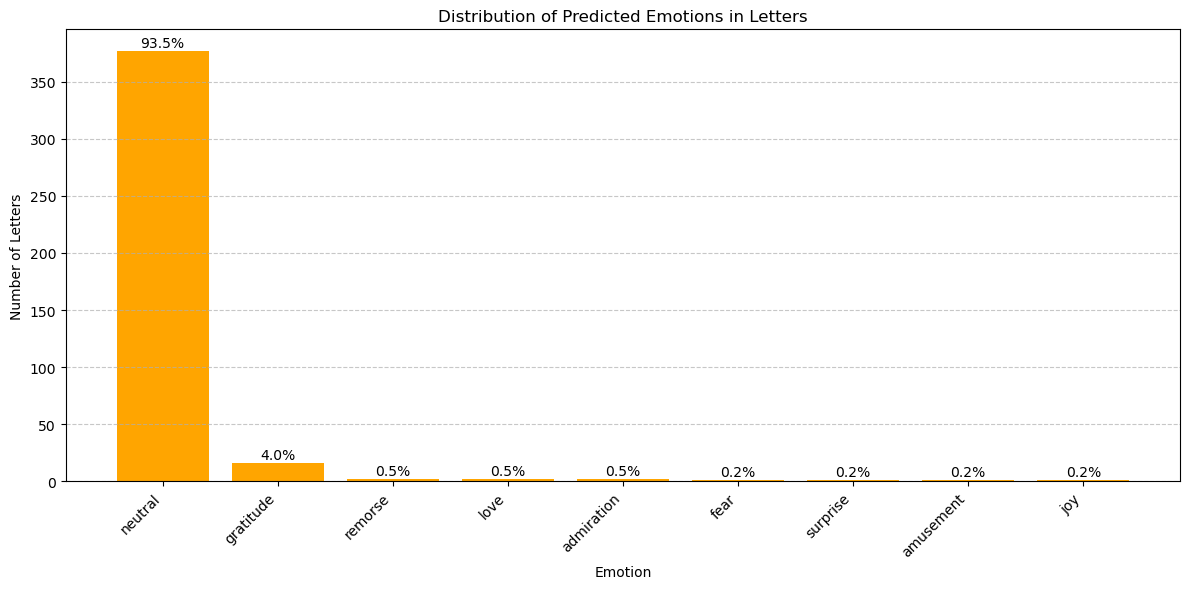

In [31]:
plot_emotion_distribution("Distribution of Predicted Emotions in Letters", output_path_2)

C:\Users\kevin\AppData\Local\Temp\ipykernel_23220\3810601873.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')


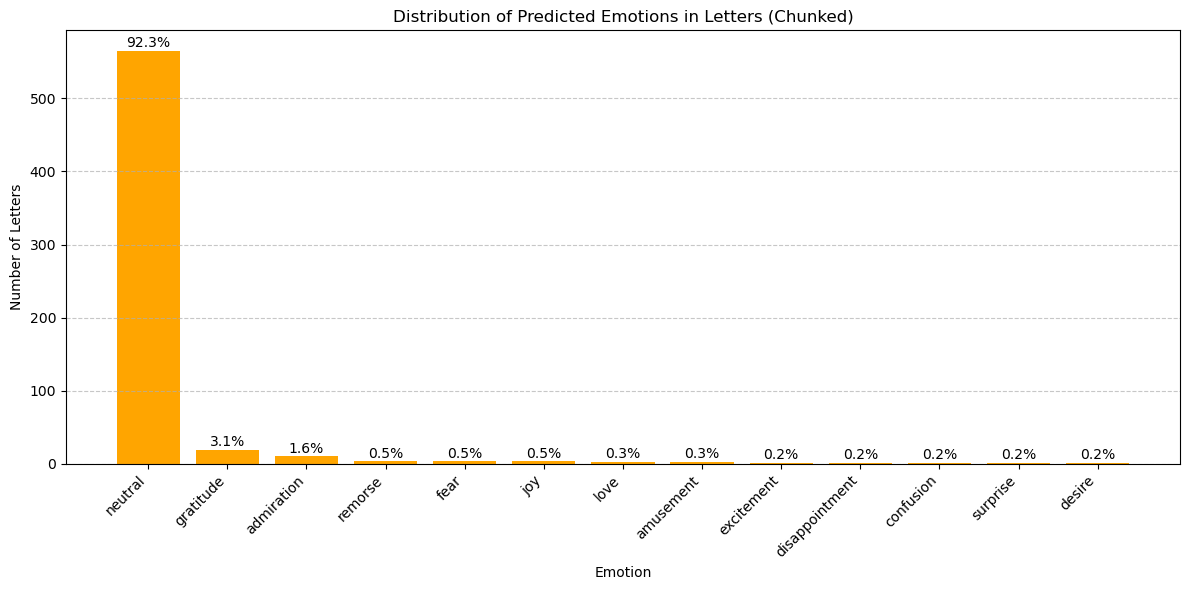

In [32]:
plot_emotion_distribution("Distribution of Predicted Emotions in Letters (Chunked)", chunk_output_path)

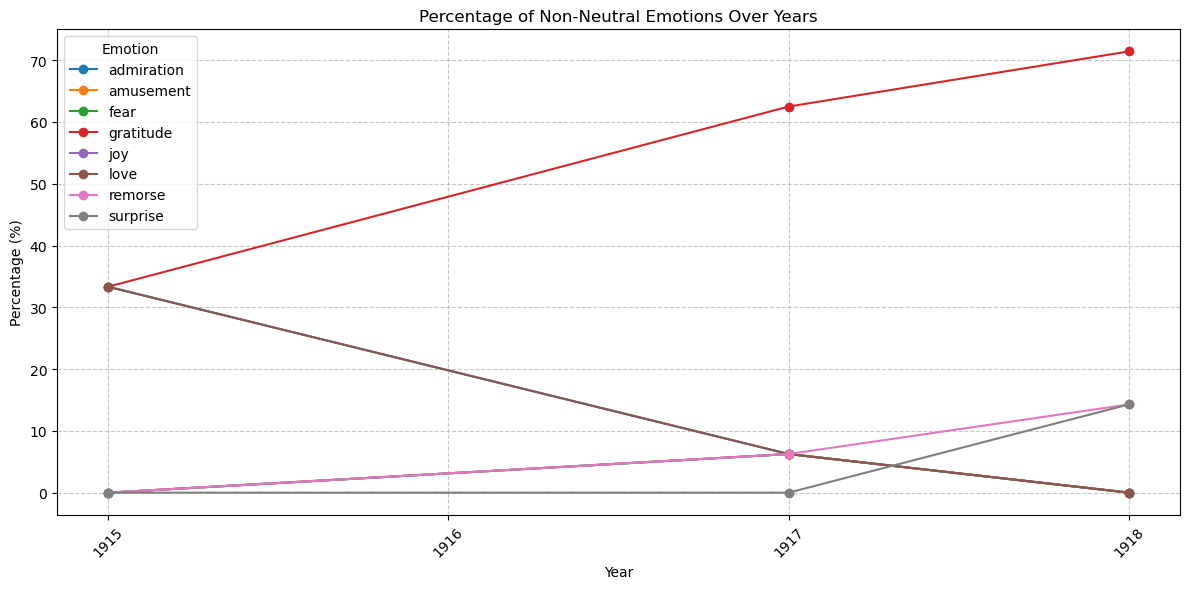

In [43]:
# Loading data
df = pd.read_csv(output_path_2)

# Drop rows where year or sentiment is missing
df = df.dropna(subset=["year", "predicted_sentiment"])

# Filtering out neutral sentiments
df_non_neutral = df[df["predicted_sentiment"].str.lower() != "neutral"]

# Grouping by year and sentiment
grouped = df_non_neutral.groupby(["year", "predicted_sentiment"]).size().reset_index(name="count")

# Getting total non-neutral counts per year
yearly_totals = grouped.groupby("year")["count"].sum().reset_index(name="total")

# Merging to calculate percentages
merged = pd.merge(grouped, yearly_totals, on="year")
merged["percentage"] = (merged["count"] / merged["total"]) * 100

# Pivot for plotting
pivot_df = merged.pivot(index="year", columns="predicted_sentiment", values="percentage").fillna(0)

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Percentage of Non-Neutral Emotions Over Years")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.legend(title="Emotion")
plt.grid(True, linestyle='--', alpha=0.7)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## DistilBERT

In [46]:
# Loading pre-trained sentiment analysis model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("assemblyai/distilbert-base-uncased-sst2")
model = AutoModelForSequenceClassification.from_pretrained("assemblyai/distilbert-base-uncased-sst2")

D:\Programs\anaconda3\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [47]:
# Loading data
data = pd.read_csv(data_path)
text_column = 'letter'

In [48]:
# Adding sentiment scores and predictions
data[['Positive_Probability', 'Negative_Probability', 'Prediction']] = data[text_column].apply(
    lambda x: pd.Series(analyze_sentiment(str(x)))
)

In [49]:
# Saving results
data.to_csv(output_path_3, index=False)
print(f"Sentiment analysis results saved to: {output_path_3}")

Sentiment analysis results saved to: ../TM2025_project/sentiment_predictions_3.csv


#### Plots

C:\Users\kevin\AppData\Local\Temp\ipykernel_23220\3810601873.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')


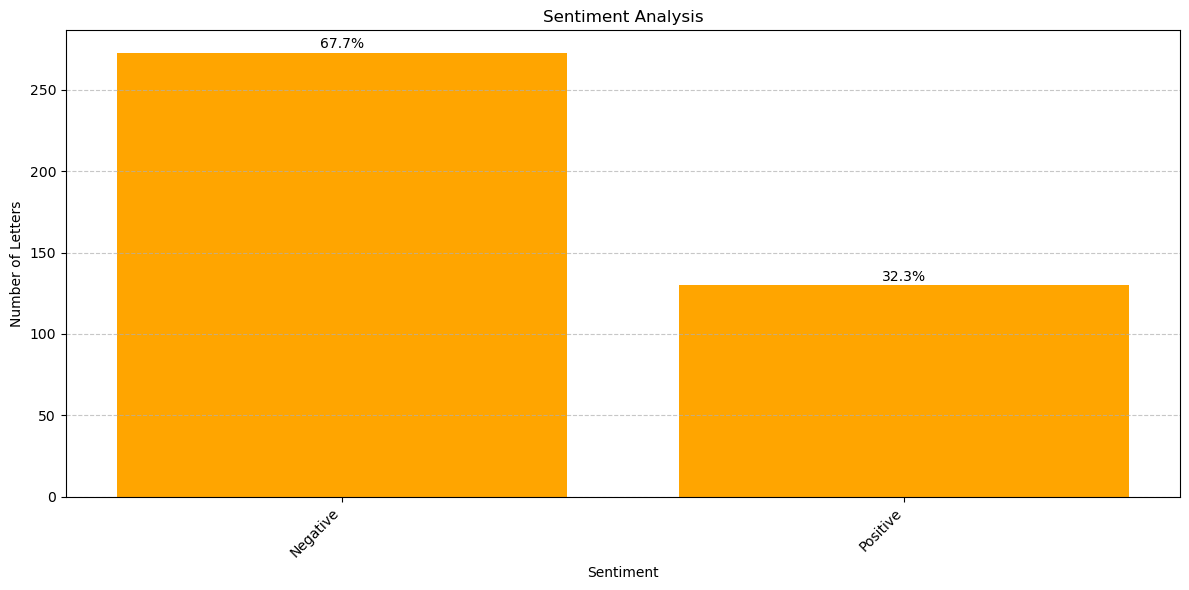

In [53]:
plot_emotion_distribution_2("Sentiment Analysis", output_path_3)

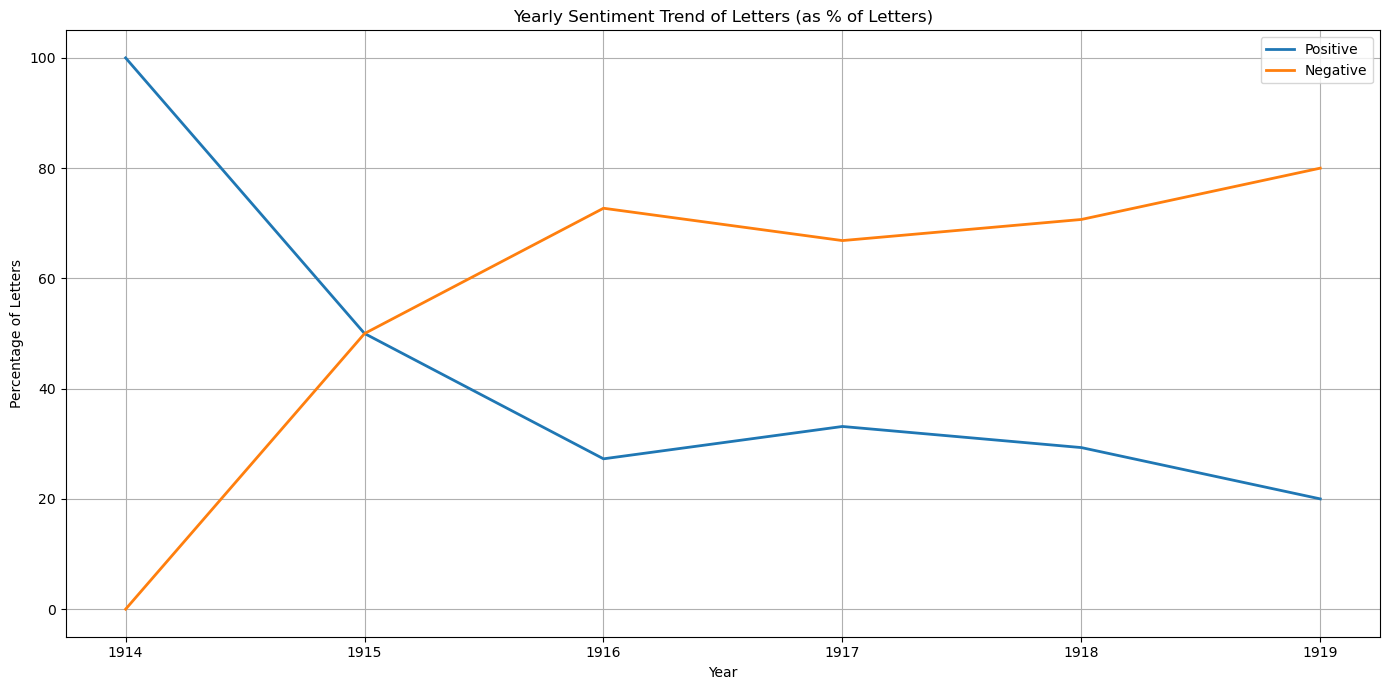

In [54]:
# Loading CSV
df = pd.read_csv(output_path_3)

# Grouping by year and sentiment prediction
yearly_sentiment = df.groupby(['year', 'Prediction']).size().unstack(fill_value=0)

# Converting counts to percentages for each year
yearly_sentiment_pct = yearly_sentiment.div(yearly_sentiment.sum(axis=1), axis=0) * 100

# Plotting
plt.figure(figsize=(14, 7))

# Ploting each sentiment line if it exists in the data
if 'Positive' in yearly_sentiment_pct.columns:
    plt.plot(yearly_sentiment_pct.index, yearly_sentiment_pct['Positive'], label='Positive', linewidth=2)
if 'Negative' in yearly_sentiment_pct.columns:
    plt.plot(yearly_sentiment_pct.index, yearly_sentiment_pct['Negative'], label='Negative', linewidth=2)

# Styling plot
plt.title("Yearly Sentiment Trend of Letters (as % of Letters)")
plt.xlabel("Year")
plt.ylabel("Percentage of Letters")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()